In [50]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.utils import shuffle
from algs_lib import *
from math import comb

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Times']})
# plt.rcParams["font.family"] = "Helvetica"

rc('text', usetex=True)

In [61]:
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

In [71]:
def load_svm(reg, noise, iso=False):
    mi_range = [1/128., 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
    x_vals = []
    y_vals = []
    for mi in mi_range:
#         if noise == False:
#             mi = 1/128. # only load for 1/128
        fname = f"hybrid_lr/iris_svm_C={reg}_mi={mi}_noise={noise}.pkl"
        if iso:
            fname = f"hybrid_lr/iris_iso_svm_C={reg}_mi={mi}_noise={noise}.pkl"
        combined = pickle.load(open(fname, 'rb'))
        accs = []
        for r in combined:
            if 100*r % 5 != 0:
                continue
            accs.append(combined[r][0]*0.5 + 0.5*(1-combined[r][1]))
        x_vals.append(np.log2(mi))
        y_vals.append(100*(max(accs) - 0.5))
    return x_vals, y_vals

def load_kmeans(noise, iso=False):
    mi_range = [1/128., 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2., 4.0]
#     mi_range = [1/128.]
    x_vals = []
    y_vals = []
    for mi in mi_range:
        fname = f"hybrid_lr/iris_kmeans_mi={mi}_noise={noise}.pkl"
        if iso:
            
            fname = f"hybrid_lr/iris_iso_kmeans_mi={mi}_noise={noise}.pkl"
        combined = pickle.load(open(fname, 'rb'))
        accs = []
        for r in combined:
            if 100*r % 5 != 0:
                continue
            accs.append(combined[r][0]*0.5 + 0.5*(1-combined[r][1]))
        x_vals.append(np.log2(mi))
        y_vals.append(100*(max(accs) - 0.5))
    return x_vals, y_vals

0
----
Iris K-Means
[9.600000000000009, 7.859599999999989, 7.557859599999994, 8.15730760805, 8.708007307359, 9.308708007307365, 7.3593087080073065, 6.606858106957258, 7.855956907406913, 10.157655807058962]
8.317126205214679
[2.0000000000000018, 0.8991500000000041, 2.4497501499999963, 2.2000007504999974, 2.350148999701096, 2.801800550500655, 4.05154950000245, 4.450900950451242, 4.951651751451158, 6.8545544509009515]
3.3009507103507554
[2.0000000000000018, 1.202000000000003, 1.1497496499999982, 1.0011497496499988, 1.4509008491502495, 1.6505010011497512, 2.701349097450745, 4.752701349097455, 4.904752701349091, 5.804353051101652]
2.661745744894894
------
[6.240999999999996, 8.814999999999994, 12.434000000000001, 17.490000000000006, 24.464, 33.789, 45.181000000000004, 49.999, 49.999, 49.999]
1
----
Iris SVM (C=1.0)
[6.000000000000005, 4.249999999999998, 6.8500000000000005, 7.699999999999996, 6.25, 5.149999999999999, 5.700000000000005, 4.600000000000004, 5.400000000000005, 5.800000000000005]

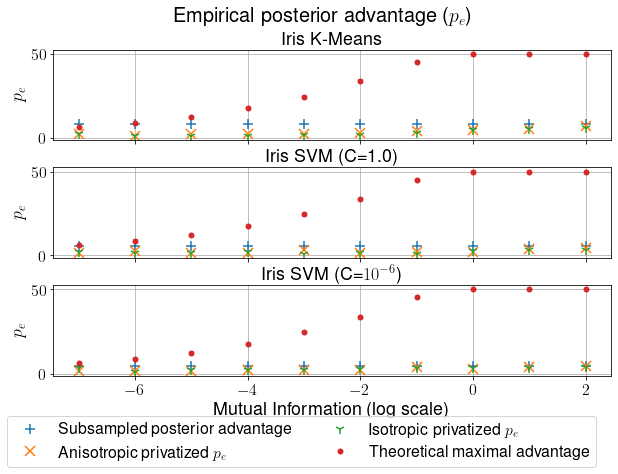

In [74]:
titles = ["Iris K-Means", "Iris SVM (C=1.0)", "Iris SVM (C=$10^{-6}$)"]
fig, axes = plt.subplots(3, sharex=True, figsize=(10, 6))
fns = [load_kmeans, load_svm, load_svm]

for ind, title in enumerate(titles):
    print(ind)
    ax = axes[ind]
#     if ind == 0: continue
    if ind == 0:
        x_vals, orig_y_vals = load_kmeans(False)
        x_vals, priv_y_vals = load_kmeans(True)
        x_vals, iso_priv_y_vals = load_kmeans(True, True)
    elif ind == 1:
#         print('orig')
        x_vals, orig_y_vals = load_svm(1.0, False)
#         print('priv')
        x_vals, priv_y_vals = load_svm(1.0, True)
#         print('iso priv')
        x_vals, iso_priv_y_vals = load_svm(1.0, True, True)
    else:
        x_vals, orig_y_vals = load_svm(1e-06, False)
        x_vals, priv_y_vals = load_svm(1e-06, True)
        x_vals, iso_priv_y_vals = load_svm(1e-06, True, True)
    print('----')
    print(titles[ind])
    
#     if ind > 0:
    print(orig_y_vals)
    print(np.average(orig_y_vals))
    print(priv_y_vals)
    print(np.average(priv_y_vals))
    print(iso_priv_y_vals)
    print(np.average(iso_priv_y_vals))
    print('------')
    theoretical_bound = [100*(calc_posterior(2**x) - 0.5) for x in x_vals]
    if ind == 0:
        print(theoretical_bound)

    ax.plot(x_vals, [np.average(orig_y_vals)]*len(orig_y_vals), '+', markersize=10, mew=1.5, label="Subsampled posterior advantage")
    ax.plot(x_vals, priv_y_vals, 'x', markersize=10, mew=1.5, label="Anisotropic privatized $p_e$")
#     print(orig_y_vals, priv_y_vals)
    ax.plot(x_vals, iso_priv_y_vals, '1', markersize=10, mew=1.5, label="Isotropic privatized $p_e$")
    ax.plot(x_vals, theoretical_bound, 'o', markersize=5, label="Theoretical maximal advantage")


    ax.set_ylabel("$p_e$", fontsize=18)
    ax.set_title(titles[ind], fontsize=18)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=16)
plt.subplots_adjust(hspace=0.3)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, ncol=2, loc=2, prop={'size': 16}, bbox_to_anchor=(0.05, 0.05))
plt.xlabel("Mutual Information (log scale)", fontsize=18)
plt.suptitle(f"Empirical posterior advantage ($p_e$)", fontsize=20)
plt.savefig('figs/empirical_posterior_adv.svg', bbox_inches = "tight")